In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## data import

In [3]:
# frame = pd.read_csv('..//1_web_scraping//apartment_details.csv')

In [4]:
query = '''
    select * from apt_details_raw
    where date = (select max(date) from apt_details_raw)
    '''

username = 'piotr'
password = os.environ['MYSQL_PASSWORD']
host = 'localhost'
db_name = 'airflow_db'
db_url = f'mysql+mysqlconnector://{username}:{password}@{host}/{db_name}'

engine = create_engine(db_url)

with engine.connect() as conn:
    frame = pd.read_sql_query(sql=query, con=conn, index_col='id')

frame.drop(['date'], axis=1, inplace=True)

for column in ['localization_y','localization_x','area','build_yr']:
    frame[column] = frame[column].astype('float')

In [5]:
frame.shape

(158036, 14)

In [6]:
frame.head()

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,
584484,Велико Търново/Veliko-tarnovo,Bułgaria,zagranica,NaN,NaN,None,None,85.00,None,None,None,NaN,505628,https://gratka.pl/nieruchomosci/mieszkanie-veliko-trnovo-veliko-tarnovo/ob/35664195
584485,Jonquière,Kanada,zagranica,NaN,NaN,None,None,188.00,więcej niż 8,None,None,NaN,768202,https://gratka.pl/nieruchomosci/mieszkanie-jonquiere/ob/36140549
584486,Łódź,Śródmieście,łódzkie,51.770949,19.461719,pierwotny,sprzedaz,48.16,3,6,None,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-lodz-srodmiescie-ul-targowa/ob/33127565
584487,Walencja,Hiszpania,zagranica,37.986672,-0.679754,wtorny,sprzedaz,57.00,3,2,5,NaN,460000,https://gratka.pl/nieruchomosci/mieszkanie-walencja/ob/32098119
584488,Setúbal Almada,Portugalia,zagranica,NaN,NaN,None,None,60.00,2,None,None,NaN,843902,https://gratka.pl/nieruchomosci/mieszkanie-setubal-almada/ob/36148581


In [7]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158036 entries, 584484 to 742519
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   city            156574 non-null  object 
 1   district        142607 non-null  object 
 2   voivodeship     156574 non-null  object 
 3   localization_y  108738 non-null  float64
 4   localization_x  108738 non-null  float64
 5   market          106194 non-null  object 
 6   offer_type      106194 non-null  object 
 7   area            156535 non-null  float64
 8   rooms           143696 non-null  object 
 9   floor           84129 non-null   object 
 10  floors          73140 non-null   object 
 11  build_yr        45255 non-null   float64
 12  price           156574 non-null  object 
 13  url             158036 non-null  object 
dtypes: float64(4), object(10)
memory usage: 18.1+ MB


In [8]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
localization_y,108738.0,48.401145,8.198050,-37.822733,49.838012,51.122047,52.333700,57.244477
localization_x,108738.0,14.795036,20.268325,-158.203783,16.948256,18.945766,20.926805,153.137724
area,156535.0,67.664434,38.257307,9.030000,44.970000,59.500000,78.750000,645.000000
build_yr,45255.0,1996.882687,35.086779,1200.000000,1976.000000,2012.000000,2023.000000,2029.000000


In [9]:
len(frame) == len(frame.drop_duplicates())

True

In [10]:
frame.offer_type.value_counts(normalize=True)

offer_type
sprzedaz    1.0
Name: proportion, dtype: float64

## renaming market type

In [11]:
frame.market.replace(['pierwotny','wtorny'], ['primary_market','aftermarket'], inplace=True)

## removing foreign locations

In [12]:
frame.voivodeship.value_counts()

voivodeship
zagranica              73187
mazowieckie            16816
pomorskie              10613
małopolskie            10498
dolnośląskie            9755
śląskie                 9121
wielkopolskie           6163
łódzkie                 4868
kujawsko-pomorskie      3922
zachodniopomorskie      3604
warmińsko-mazurskie     2003
lubelskie               1819
podkarpackie            1289
świętokrzyskie          1073
lubuskie                 668
opolskie                 639
podlaskie                536
Name: count, dtype: int64

In [13]:
len(frame[frame.voivodeship=='zagranica'])/len(frame)

0.4631033435419778

In [14]:
frame.drop(frame[frame.voivodeship=='zagranica'].index, inplace=True)

In [15]:
frame.shape

(84849, 14)

## removing data with no price

In [16]:
frame.price.value_counts(normalize=True).loc['Zapytajoce']

0.24022929233573578

In [17]:
frame.drop(index=frame[frame.price=='Zapytajoce'].index, axis=0, inplace=True)

In [18]:
frame.price = frame.price.astype('float')

In [19]:
frame.shape

(64817, 14)

## checking the amount of missing data and removing rows with small amount of missing data per column

In [20]:
num_desc = frame.describe().T
num_desc['%missing'] = (1-num_desc['count']/len(frame))*100
num_desc

,count,mean,std,min,25%,50%,75%,max,%missing
localization_y,63168.0,51.912713,1.470293,41.616750,50.440250,52.129926,53.083479,5.483390e+01,2.544086
localization_x,63168.0,19.035598,1.846565,14.220168,17.956396,19.058384,20.640770,4.163675e+01,2.544086
area,63316.0,55.002248,21.624974,9.030000,41.100000,51.470000,63.700000,4.853000e+02,2.315750
build_yr,44215.0,1996.312270,35.266625,1200.000000,1975.000000,2012.000000,2023.000000,2.027000e+03,31.784871
price,63355.0,673911.188115,499559.258341,1.000000,402932.000000,584528.000000,799000.000000,4.320000e+07,2.255581


In [21]:
obj_desc = frame.describe(include=['object']).T
obj_desc['%missing'] = (1-obj_desc['count']/len(frame))*100
obj_desc

,count,unique,top,freq,%missing
city,63355,1741,Warszawa,9884,2.255581
district,52457,1162,Śródmieście,2536,19.069071
voivodeship,63355,16,mazowieckie,12196,2.255581
market,61892,2,aftermarket,42038,4.512705
offer_type,61892,1,sprzedaz,61892,4.512705
rooms,63153,8,2,26444,2.567228
floor,62853,32,1,14541,3.030069
floors,59283,31,4,17160,8.537884
url,64817,64817,https://gratka.pl/nieruchomosci/nowe-mieszkanie-kielce-ul-artylerzystow/ob/34717581,1,0.0


In [22]:
frame.dropna(subset=['price','localization_y','localization_x','area'], axis=0, inplace=True)

In [23]:
frame.dropna(subset=['market','offer_type','rooms','floor'], axis=0, inplace=True)

In [24]:
frame.shape

(61322, 14)

## dealing with missing data for 'floors', 'district', 'build_yr'

In [25]:
frame.dropna(subset=['build_yr'], axis=0, inplace=True)

In [26]:
len(frame[pd.isnull(frame.floors)])/len(frame)

0.018018839951645646

In [27]:
frame.dropna(subset=['floors'], axis=0, inplace=True)

In [28]:
# district will be left with missing data

In [29]:
frame.shape

(43053, 14)

## checking categorical data

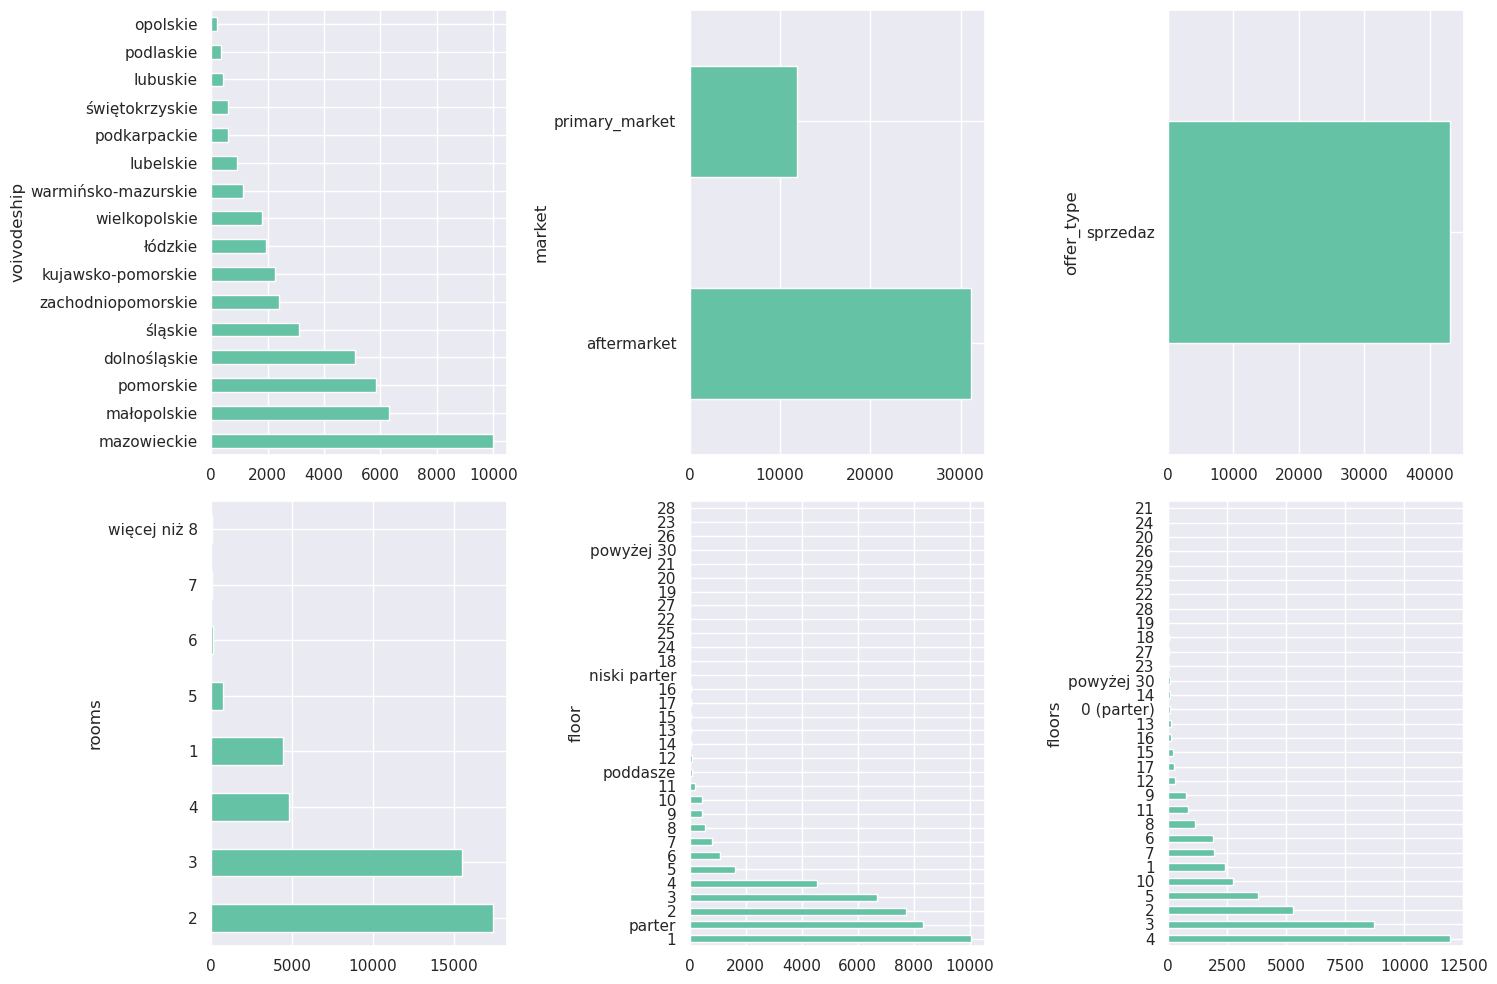

In [30]:
fig, axList = plt.subplots(nrows=2, ncols=3)
axList = axList.flatten()
fig.set_size_inches(15,10)

catagorical_columns = [x for x in frame.columns if frame[x].dtype == 'object' and x not in ['city','district','url']]

for ax, column in zip(axList, catagorical_columns):
    frame[column].value_counts().plot(kind='barh', ax=ax, ylabel=column)
    
plt.tight_layout()

In [31]:
frame.rooms.replace('więcej niż 8', '8', inplace=True)
frame.rooms = frame.rooms.astype('int')

In [32]:
frame.floor.replace(['niski parter','parter'], '0', inplace=True)
frame.floor.replace('powyżej 30', '30', inplace=True)
frame.drop(frame[frame.floor=='poddasze'].index, axis=0, inplace=True)
frame.floor = frame.floor.astype('int')

In [33]:
frame.floors.replace(['0 (parter)','powyżej 30'], ['0','30'], inplace=True)
frame.floors = frame.floors.astype('int')

In [34]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42957 entries, 584491 to 742517
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            42957 non-null  object 
 1   district        36654 non-null  object 
 2   voivodeship     42957 non-null  object 
 3   localization_y  42957 non-null  float64
 4   localization_x  42957 non-null  float64
 5   market          42957 non-null  object 
 6   offer_type      42957 non-null  object 
 7   area            42957 non-null  float64
 8   rooms           42957 non-null  int64  
 9   floor           42957 non-null  int64  
 10  floors          42957 non-null  int64  
 11  build_yr        42957 non-null  float64
 12  price           42957 non-null  float64
 13  url             42957 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 4.9+ MB


In [35]:
frame.shape

(42957, 14)

## adding custom column

In [36]:
frame['price_of_sqm'] = frame.price / frame.area

## dealing with outliers

In [37]:
# checking quantile values

outliers_dict = dict()

for column in ['area','build_yr','price','price_of_sqm']:
    upper_quartile = np.nanpercentile(frame[column], 99.0)
    lower_quartile = np.nanpercentile(frame[column], 1.0)
#     iqr = upper_quartile - lower_quartile
#     outliers_dict[column] = (lower_quartile-1.5*iqr, upper_quartile+1.5*iqr)
    outliers_dict[column] = (lower_quartile, upper_quartile)

outliers_dict

{'area': (22.44, 130.1572000000003),
 'build_yr': (1900.0, 2026.0),
 'price': (180000.0, 2641040.0000000373),
 'price_of_sqm': (3695.398590387702, 30638.43766117304)}

In [38]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,42957.0,55.874347,22.376448,9.03,41.54,52.250000,64.73000,431.0
build_yr,42957.0,1996.336942,35.063273,1200.00,1975.00,2011.000000,2023.00000,2027.0
price,42957.0,733705.850921,502338.751821,75000.00,450000.00,638560.000000,857400.00000,12900000.0
price_of_sqm,42957.0,13332.807509,6095.593373,937.50,8950.00,12496.307238,16705.69857,279960.0


In [39]:
outliers_dict['build_yr'] = (1900.0, 2024.0)

In [40]:
for key in outliers_dict.keys():
    frame.drop(frame[frame[key] < outliers_dict[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict[key][1]].index, inplace = True)

In [41]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,36691.0,55.050411,18.228081,22.440000,42.200000,52.360000,64.100000,1.301000e+02
build_yr,36691.0,1995.320351,30.938545,1900.000000,1975.000000,2008.000000,2023.000000,2.024000e+03
price,36691.0,705182.135183,359355.162684,180000.000000,459000.000000,640000.000000,850000.000000,2.631200e+06
price_of_sqm,36691.0,13101.514005,5316.510656,3696.857671,8928.571429,12410.714286,16556.122449,3.063209e+04


In [42]:
len(frame[frame.floor>15]), len(frame[frame.floors>15])

(102, 562)

In [43]:
frame.drop(frame[frame.floor>15].index, axis=0, inplace=True)
frame.drop(frame[frame.floors>15].index, axis=0, inplace=True)

In [44]:
len(frame[frame.rooms>6])

12

In [45]:
frame.drop(frame[frame.rooms>6].index, axis=0, inplace=True)

In [46]:
frame.shape

(36117, 15)

## dealing with outliers in localization

In [47]:
frame.localization_x.min(), frame.localization_x.max()

(14.2201684, 23.6725471)

In [48]:
frame.localization_y.min(), frame.localization_y.max()

(48.17369, 54.8339)

In [49]:
outliers_dict_2 = dict()
outliers_dict_2['localization_x'] = (14,25)
outliers_dict_2['localization_y'] = (48,55)

In [50]:
for key in outliers_dict_2.keys():
    frame.drop(frame[frame[key] < outliers_dict_2[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict_2[key][1]].index, inplace = True)

In [51]:
len(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)])

19

In [52]:
frame.drop(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)].index,inplace=True)

In [53]:
frame.shape

(36098, 15)

## checking histograms

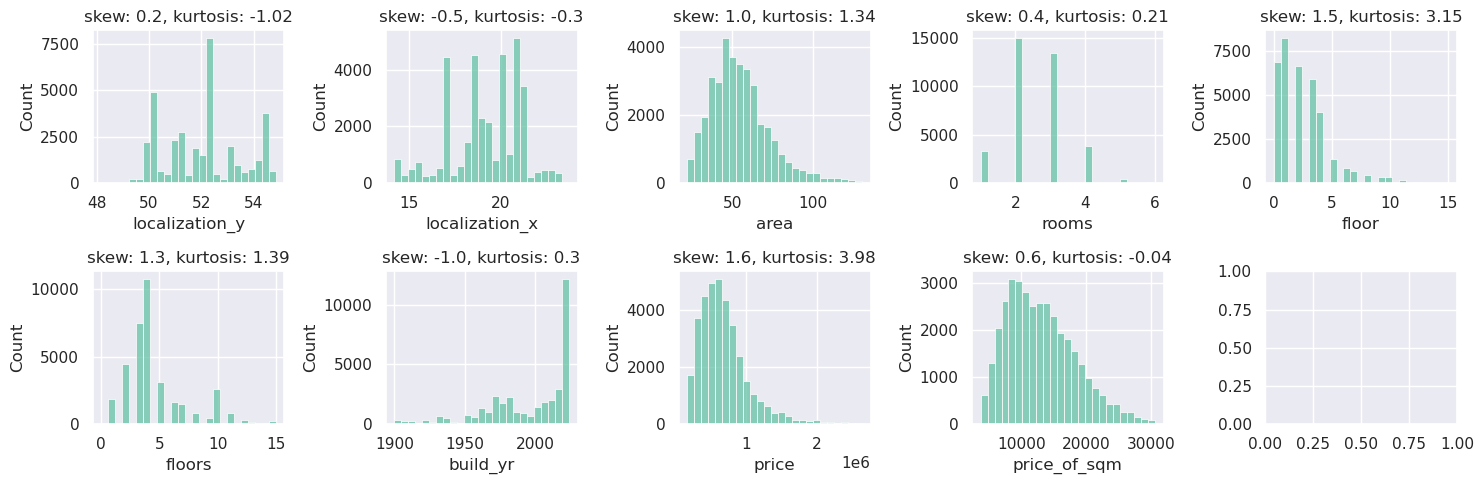

In [54]:
fig, axList = plt.subplots(nrows=2, ncols=5)
axList = axList.flatten()
fig.set_size_inches(15,5)

numeric_columns = [x for x in frame.columns if frame[x].dtype in ['float64','int64']]
kurtosis_dict = dict(frame[numeric_columns].kurtosis())

for ax, column in zip(axList, numeric_columns):
    sns.histplot(frame, x=frame[column], ax=ax, bins=25)
    ax.title.set_text(f'skew: {round(frame[column].skew(), 1)}, kurtosis: {round(kurtosis_dict[column], 2)}')
    
plt.tight_layout()

## data summary

In [55]:
round(frame.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
localization_y,36098.0,52.01,1.47,48.17,50.87,52.18,53.12,54.83
localization_x,36098.0,19.15,1.91,14.22,18.02,19.42,20.92,23.67
area,36098.0,55.04,18.22,22.44,42.19,52.40,64.10,130.10
rooms,36098.0,2.54,0.86,1.00,2.00,2.00,3.00,6.00
floor,36098.0,2.37,2.21,0.00,1.00,2.00,3.00,15.00
floors,36098.0,4.60,2.73,0.00,3.00,4.00,5.00,15.00
build_yr,36098.0,1995.07,31.03,1900.00,1975.00,2008.00,2023.00,2024.00
price,36098.0,700353.44,356509.48,180000.00,455000.00,637000.00,849000.00,2631200.00
price_of_sqm,36098.0,13016.44,5274.58,3696.86,8900.00,12323.59,16451.45,30632.09


In [56]:
frame.describe(include=['object']).T

,count,unique,top,freq
city,36098,1061,Warszawa,6873
district,30621,1042,Śródmieście,1515
voivodeship,36098,16,mazowieckie,8431
market,36098,2,aftermarket,28401
offer_type,36098,1,sprzedaz,36098
url,36098,36098,https://gratka.pl/nieruchomosci/mieszkanie-wroclaw-ul-kamienna/ob/36396823,1


In [57]:
frame.reset_index(drop=True, inplace=True)

In [58]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36098 entries, 0 to 36097
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            36098 non-null  object 
 1   district        30621 non-null  object 
 2   voivodeship     36098 non-null  object 
 3   localization_y  36098 non-null  float64
 4   localization_x  36098 non-null  float64
 5   market          36098 non-null  object 
 6   offer_type      36098 non-null  object 
 7   area            36098 non-null  float64
 8   rooms           36098 non-null  int64  
 9   floor           36098 non-null  int64  
 10  floors          36098 non-null  int64  
 11  build_yr        36098 non-null  float64
 12  price           36098 non-null  float64
 13  url             36098 non-null  object 
 14  price_of_sqm    36098 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 4.1+ MB


## saving the frame

In [59]:
# outfile = open('apartment_data_frame','wb')
# pkl.dump(frame, outfile)
# outfile.close()